In [79]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def plotpar_fromfile(filename, xlab, ylab, xscale='linear', yscale='linear', a=0, b=0, xfile='', return_par=False):
    est, Ntrue, err= np.loadtxt(filename)
    if xfile!='': Ntrue,N,newx_err=np.loadtxt(xfile) #metto il parametro in Ntrue
    
    out=open(filename)
    line1=out.readline()
    line2=out.readline()
    param=np.fromstring(line1[2:], sep=' ')
    name=line2[2:].split()
    out.close()
    
    print('last value:', est[-1])
    plt.figure(figsize=(15,5))
    if xfile=='': plt.errorbar(Ntrue, est, yerr=err)
    else: plt.errorbar(Ntrue, est, yerr=err, xerr=newx_err)
    plt.xscale(xscale)
    plt.yscale(yscale)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.grid()
    plt.title(name[0]+'='+str(round(param[0], 2))+', '+name[1]+'='+str(round(param[1], 2))+', '+
              name[2]+'='+str(param[2])+', '+name[3]+'='+str(param[3]))
    if a<b:
        passedA=False
        for i in range(len(Ntrue)):
            if Ntrue[i]>a and not(passedA):
                a=i
                passedA=True
                
            if Ntrue[i]>b: break
            else: b_ind=i
        
        x=Ntrue[a:b_ind].reshape(-1,1)
        y=  est[a:b_ind].reshape(-1,1)
        if xscale=='log': x_reg=np.log10(x)
        else: x_reg=x
        
        if yscale=='log': y_reg=np.log10(y)
        else: y_reg=y
            
        model  = LinearRegression().fit(x_reg,y_reg)
        
        if yscale=='log': plt.plot(x,10 ** model.predict(x_reg), color='red')
        else: plt.plot(x,model.predict(x_reg), color='red')
        print('coefficient:',model.coef_[0][0])
        print('mean squared error:', mean_squared_error(y_reg, model.predict(x_reg)) )
    plt.show()
    if return_par: return model.coef_[0][0], mean_squared_error(y_reg, model.predict(x_reg))

last value: 5.987733500509287


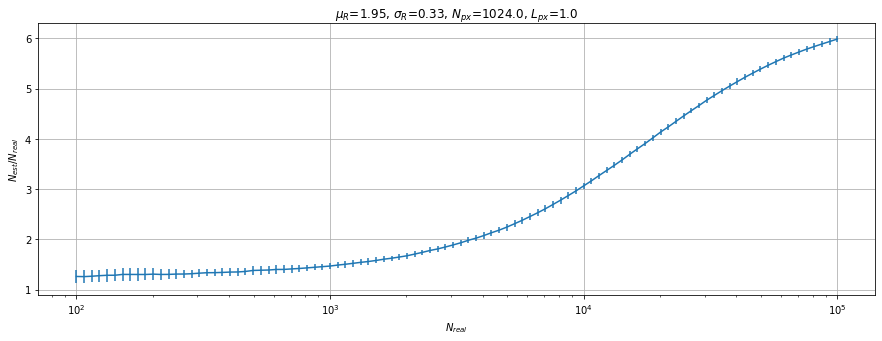

In [8]:
plotpar_fromfile('scaling_mpi/N_relvsN.dat', r'$N_{real}$', r'$N_{est} / N_{real}$', xscale='log', yscale='linear')#, a=80,b=5000)
#plotpar_fromfile('scaling_mpi/V_relvsN.dat', r'$N_{real}$', r'$V_{est} / V_{real}$', xscale='log', yscale='linear')#, a=80,b=5000)
#plt.figure(figsize=(15,5))
#plt.plot(h[],)

last value: 1339.2797108560692


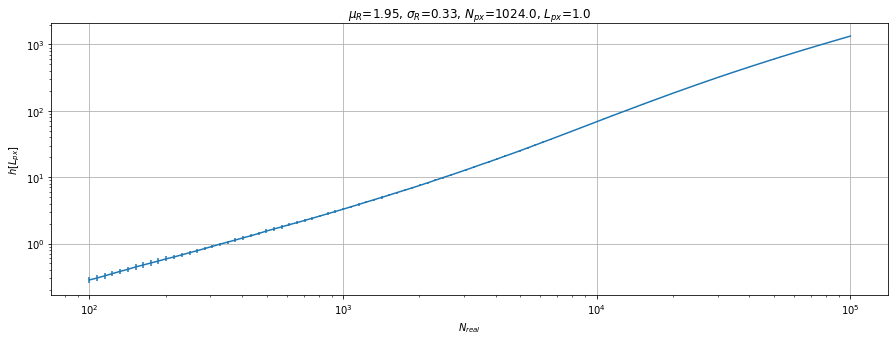

last value: 1674.453671255784


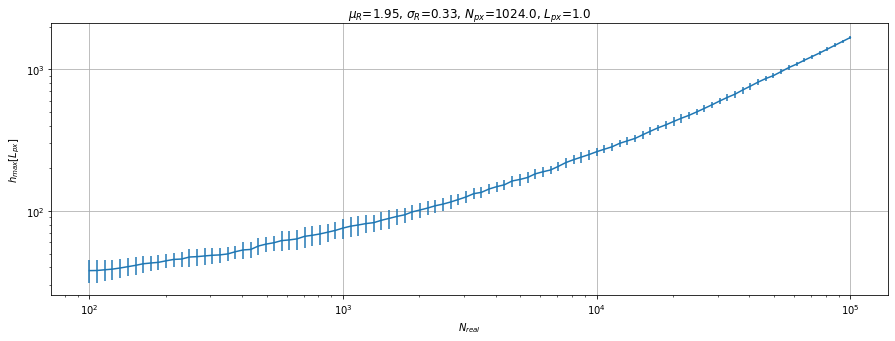

In [78]:
plotpar_fromfile('scaling_mpi/hvsN.dat', r'$N_{real}$', r'$h [L_{px}]$', xscale='log', yscale='log')#, a=100, b=10000)
plotpar_fromfile('scaling_mpi/maxhvsN.dat', r'$N_{real}$', r'$h_{max} [L_{px}]$', xscale='log', yscale='log')#, a=10,b=1000)

last value: 124.35106573631195
coefficient: 0.5768150685991921
mean squared error: 9.332893693187705e-05


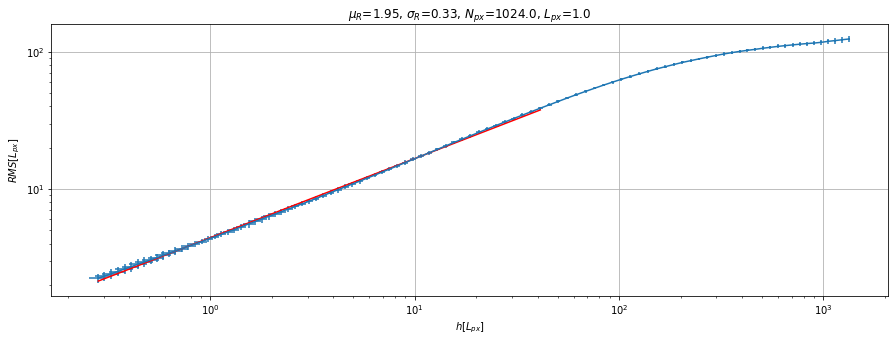

In [107]:
beta, beta_err= plotpar_fromfile('scaling_mpi/rmsvsN.dat', r'$h [L_{px}]$', r'$RMS [L_{px}]$', xscale='log', yscale='log', a=0,b=50, xfile='scaling_mpi/hvsN.dat', return_par=True)

In [102]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit

def G_gauss_prof(lLw, alfa):
    l_xy,L,w=lLw
    return 2*w**2 *( 1-np.exp(- (l_xy/L)**(2*alfa)) )

def G_red_gauss_prof(lL, alfa):
    l_xy,L=lL
    return 1-np.exp(- (l_xy/L)**(2*alfa))

#def G_red_linearized()

def plotcorr_fromfile(filename, Nline, xscale='linear', yscale='linear', a=0, b=0, L=-1, plotting=True, fit=False):
    ind=filename.find('/')
    Nrel, Ntrue=np.loadtxt(filename[:ind+1]+'N_relvsN.dat', max_rows=2)
    rms= np.loadtxt(filename[:ind+1]+'rmsvsN.dat', max_rows=1)
    x=np.loadtxt(filename[:ind+1]+'x.dat')
    
    out=open(filename)
    for i in range(Nline-1): out.readline()
    line=out.readline()
    y=np.fromstring(line, sep=' ')
    out.close()
    if filename[ind+1]=='C': y/=rms[Nline-1]**2
    if filename[ind+1]=='G': y/=2*rms[Nline-1]**2
    
    out=open(filename[:ind+2]+'2.dat')
    for i in range(Nline-1): out.readline()
    line=out.readline()
    err=np.sqrt(abs(np.fromstring(line, sep=' ')))
    out.close()
    
    if plotting:
        plt.figure(figsize=(15,5))
        #plt.errorbar(x, y, yerr=err)
        plt.plot(x,y)
        if filename[ind+1]=='C': plt.xlim(0,b+50)
        plt.xscale(xscale)
        plt.yscale(yscale)
        plt.xlabel(r'$r [L_{px}]$')
        plt.ylabel(filename[ind+1]+'$[L_{px}]$')
        plt.grid()
        if filename[ind+1]=='C': plt.title('height correlation function, N='+str(Ntrue[Nline-1])+', RMS='+str(round(rms[Nline-1], 2))+' Lpx')
        if filename[ind+1]=='G': plt.title('height-height correlation function, N='+str(Ntrue[Nline-1])+', RMS='+str(round(rms[Nline-1], 2))+' Lpx')
    
    if L>0 and filename[ind+1]=='G' and fit:
        opt,cov= curve_fit(G_red_gauss_prof, (x, np.ones(len(x))*L), y, bounds=(0,2))
#        print(opt, cov[0])
        if plotting: plt.plot(x,G_red_gauss_prof((x, np.ones(len(x))*L),opt[0]), ls='dashed')

    if a<b and not(fit):
        passedA=False
        for i in range(len(x)):
            if x[i]>a and not(passedA):
                a=i
                passedA=True
                
            if x[i]>b: break
            else: b_ind=i
        
        x=x[a:b_ind].reshape(-1,1)
        y=  y[a:b_ind].reshape(-1,1)
        if xscale=='log': x_reg=np.log10(x)
        else: x_reg=x
        
        if yscale=='log': y_reg=np.log10(y)
        else: y_reg=y
            
        model  = LinearRegression().fit(x_reg,y_reg)
        
        if plotting:
            if yscale=='log': plt.plot(x,10 ** model.predict(x_reg), color='red', ls='dashed')
            else: plt.plot(x,model.predict(x_reg), color='red', ls='dashed')
#            print('coefficient:',model.coef_[0][0])
#            print('mean squared error:', mean_squared_error(y_reg, model.predict(x_reg)) )
#    plt.show()
        if filename[ind+1]=='C': return - model.coef_[0][0]**-1 *np.log10(np.exp(1)), np.sqrt(mean_squared_error(y_reg, model.predict(x_reg))) *np.log10(np.exp(1))/ model.coef_[0][0]
        if filename[ind+1]=='G': return model.coef_[0][0]/2, np.sqrt(mean_squared_error(y_reg, model.predict(x_reg)))/2
    if L>0 and filename[ind+1]=='G': return opt[0], cov[0][0]

correl length: 14.848395770659614
alpha: 0.7535150959755067
alpha: 0.6393225987015954


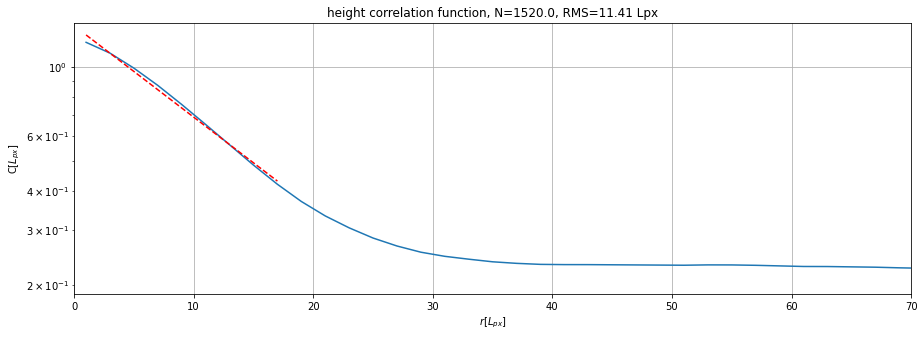

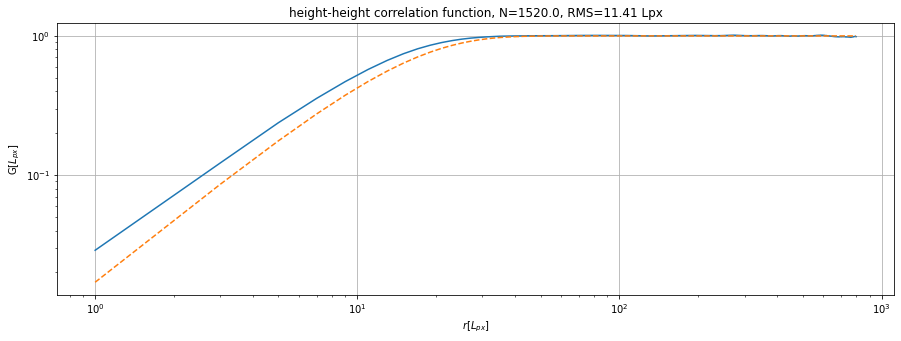

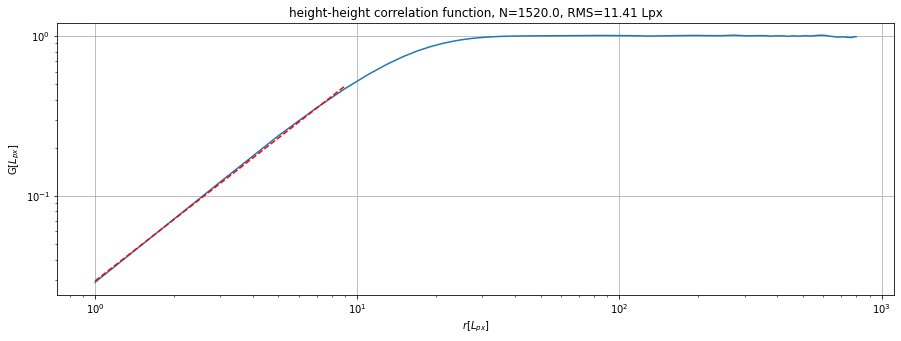

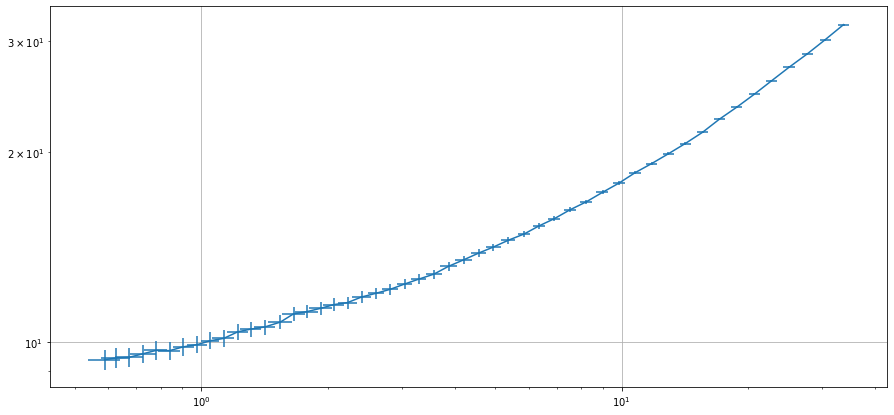

In [113]:
lll=40
p,e=plotcorr_fromfile('scaling_mpi/C.dat', lll, xscale='linear', yscale='log', a=0,b=20)
print('correl length:', p)
p,e=plotcorr_fromfile('scaling_mpi/G.dat', lll, xscale='log', yscale='log', a=0,b=11, L=p, fit=True)
print('alpha:', p)
p,e=plotcorr_fromfile('scaling_mpi/G.dat', lll, xscale='log', yscale='log', a=0,b=11, L=p)
print('alpha:', p)

Lcorr=np.array([])
L_err=np.array([])

Nlin=np.arange(10,60)
for i in Nlin:
    p,e=plotcorr_fromfile('scaling_mpi/C.dat', i, xscale='linear', yscale='log', a=0,b=20, plotting=False)
    Lcorr=np.append(Lcorr, p)
    L_err=np.append(L_err, e)

h, Ntrue, h_err=np.loadtxt('scaling_mpi/hvsN.dat')
plt.figure(figsize=(15,7))
plt.errorbar(h[Nlin], Lcorr, yerr=L_err, xerr=h_err[Nlin])
plt.xscale('log')
plt.yscale('log')
plt.grid()

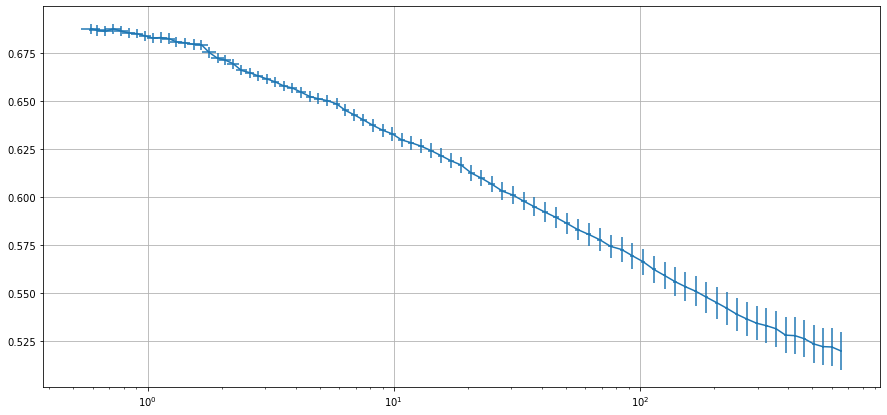

In [90]:
alfa =np.array([])
alfa_err=np.array([])

for i in Nlin: #wrong ppppppppppppppppppppppp!
    p,e=plotcorr_fromfile('scaling_mpi/G.dat', i, xscale='log', yscale='log', a=0,b=10, L=p, plotting=False)
    alfa=np.append(alfa, p)
    alfa_err=np.append(alfa_err, e)

plt.figure(figsize=(15,7))
plt.errorbar(h[Nlin], alfa, yerr=alfa_err, xerr=h_err[Nlin])
plt.xscale('log')
#plt.yscale('log')
plt.grid()
plt.show()

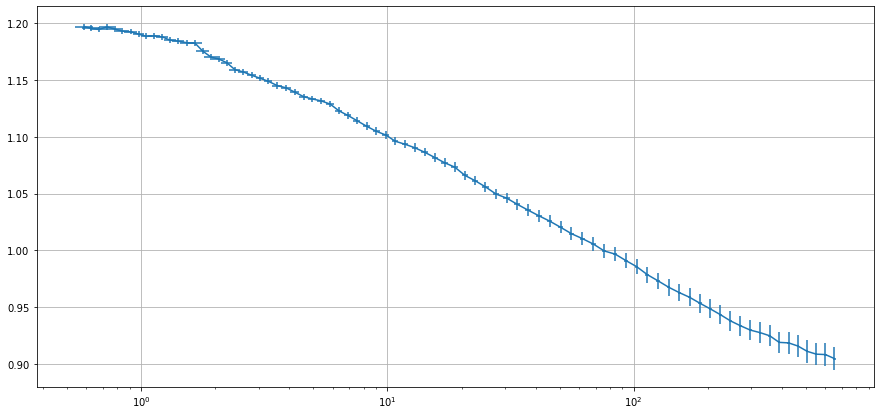

In [91]:
plt.figure(figsize=(15,7))
plt.errorbar(h[Nlin], alfa/beta, yerr=alfa_err, xerr=h_err[Nlin])
plt.xscale('log')
#plt.yscale('log')
plt.grid()
plt.show()